# Beak Data Challenge - Data Analyst
## KPI Documentation

In [27]:
### This is a terrible approach use only in testing
import sys
sys.path.insert(1, 'G:\\My Drive\\Luis Eduardo Higuera Calderon\\Proyectos\\Beek.io\\Beak Data Challenge\\src')
from apps.visual_backend import DashPlotting
import apps.backend as backend

Plot = DashPlotting()

In [28]:
import pandas as pd

## Get dataframe from postgreSQL DB for users SUBSCRIBED

In [29]:
def get_users_subscribed_audiobook_plays(start, end):
    """ Query first_plays and last_plays of the users from the audiobook_plays

    Args:
        start (): 
        end (): 

    Returns:
        pandas.core.frame.DataFrame: DataFrame
    """

    df_users = backend.runQuery(f"""
        WITH first_time_played(user_id, first_play, last_play, has_been_subscribed) AS (
            SELECT DISTINCT ap.user_id
            , DATE_TRUNC('day', FIRST_VALUE(ap.created_at) OVER (PARTITION BY ap.user_id ORDER BY ap.created_at))::date
            , DATE_TRUNC('day', FIRST_VALUE(ap.created_at) OVER (PARTITION BY ap.user_id ORDER BY ap.created_at DESC))::date
            , has_been_subscribed
            FROM audiobook_plays ap
            INNER JOIN users us
            ON ap.user_id = us.id
            WHERE ap.created_at BETWEEN '{start}'::TIMESTAMP AND '{end}'::TIMESTAMP
        )
        SELECT first_play,
            last_play,
            has_been_subscribed
        FROM first_time_played;
    """)

    return df_users

In [30]:
#
df = get_users_subscribed_audiobook_plays('2018-12-01','2019-04-30')
df

,first_play,last_play,has_been_subscribed
0,2018-12-30,2019-04-10,False
1,2018-12-15,2019-04-01,True
2,2018-12-23,2019-04-10,True
3,2019-01-30,2019-02-13,True
4,2019-02-03,2019-02-03,True
...,...,...,...
2794,2019-04-10,2019-04-10,True
2795,2019-04-10,2019-04-10,True
2796,2019-04-10,2019-04-10,True
2797,2019-04-10,2019-04-10,True


In [31]:
df.describe()

,first_play,last_play,has_been_subscribed
count,2799,2799,2799
unique,120,120,2
top,2019-01-20,2019-04-10,True
freq,78,118,2524


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2799 entries, 0 to 2798
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   first_play           2799 non-null   object
 1   last_play            2799 non-null   object
 2   has_been_subscribed  2799 non-null   bool  
dtypes: bool(1), object(2)
memory usage: 46.6+ KB


In [33]:
# Change data types of the dates columns
df['first_play'] = pd.to_datetime(df['first_play'])
df['last_play'] = pd.to_datetime(df['last_play'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2799 entries, 0 to 2798
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   first_play           2799 non-null   datetime64[ns]
 1   last_play            2799 non-null   datetime64[ns]
 2   has_been_subscribed  2799 non-null   bool          
dtypes: bool(1), datetime64[ns](2)
memory usage: 46.6 KB


In [34]:
df

,first_play,last_play,has_been_subscribed
0,2018-12-30,2019-04-10,False
1,2018-12-15,2019-04-01,True
2,2018-12-23,2019-04-10,True
3,2019-01-30,2019-02-13,True
4,2019-02-03,2019-02-03,True
...,...,...,...
2794,2019-04-10,2019-04-10,True
2795,2019-04-10,2019-04-10,True
2796,2019-04-10,2019-04-10,True
2797,2019-04-10,2019-04-10,True


## Create a function to transform dataframe

In [35]:
def cummulative(column, mask=pd.Series(dtype='float64')):
    if mask.empty:
        count_series = column.value_counts()
    else:
        count_series = column[mask].value_counts()
        
    count_df = pd.DataFrame(count_series)
    count_df.reset_index(inplace=True)
    count_df.rename(columns={'index':'date', 'first_play':'users_subscribed'}, inplace=True)
    count_df.sort_values(by='date', inplace=True)
    count_df['cumm_users_subscribed'] = count_df['users_subscribed'].cumsum()
    return count_df

In [36]:
### get cummulative of frequencys
is_subscribed_mask = df['has_been_subscribed']==True
#cummulative = pd.Series(df['first_play'][is_subscribed_mask]).value_counts()
users_subscribed = cummulative(df['first_play'], is_subscribed_mask)
users_subscribed.head()

,date,users_subscribed,cumm_users_subscribed
96,2018-12-09,11,11
114,2018-12-10,4,15
109,2018-12-11,6,21
117,2018-12-12,3,24
113,2018-12-14,5,29


In [37]:
### Filter by date between
start_date = '2018-12-11'
end_date =  '2019-02-28'
between_mask = (users_subscribed['date'] > start_date) & (users_subscribed['date'] < end_date)
users_subscribed_between = users_subscribed[between_mask]

In [38]:
'2018-12-09'.split()[0]

'2018-12-09'

## Subscribed user plot

In [39]:
import plotly.graph_objects as go
import plotly.express as px

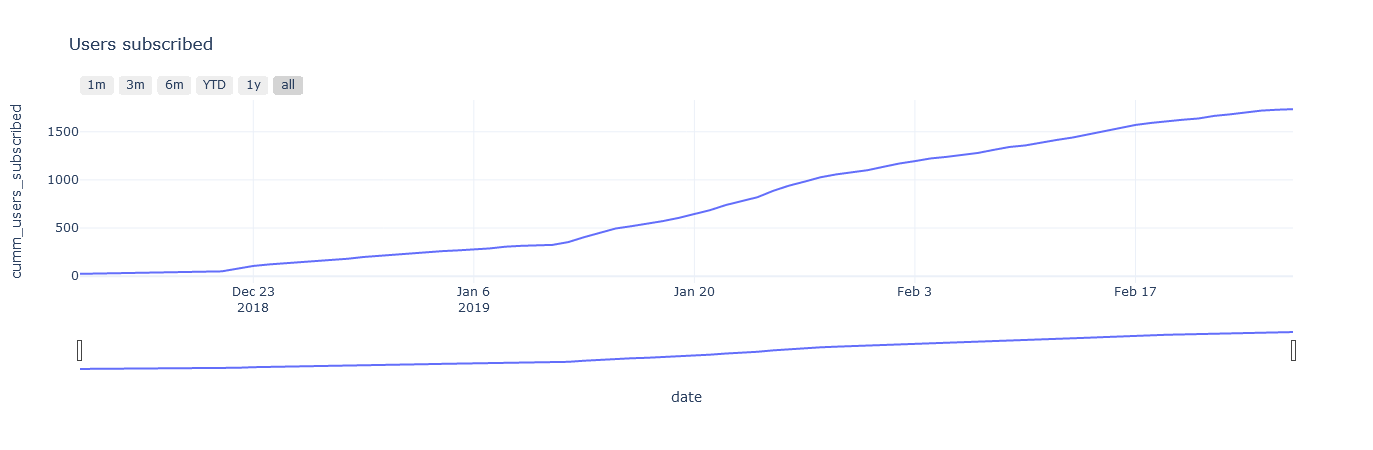

In [40]:
fig = Plot.time_series(users_subscribed_between, x_data='date', y_data='cumm_users_subscribed', title='Users subscribed', selector_slider=True)
go.Figure(data=fig)
fig.show()

In [41]:
users_subscribed.tail()

,date,users_subscribed,cumm_users_subscribed
35,2019-04-06,26,2436
56,2019-04-07,20,2456
13,2019-04-08,35,2491
60,2019-04-09,18,2509
78,2019-04-10,15,2524


## Calcule KPI's

In [42]:
#calcule min and max users suscribed in the dates provided
min_users_subscribed = users_subscribed['cumm_users_subscribed'].min()
max_users_subscribed = users_subscribed['cumm_users_subscribed'].max()


#calcule new users in interval
new_users_subscribed = max_users_subscribed-min_users_subscribed
# percentage of users
perc_users_subscribed = new_users_subscribed/max_users_subscribed

In [43]:
users = cummulative(df['first_play'])
between_mask = (users['date'] > start_date) & (users['date'] < end_date)
users_between = users[between_mask]
users.tail()

,date,users_subscribed,cumm_users_subscribed
39,2019-04-06,26,2710
55,2019-04-07,20,2730
18,2019-04-08,36,2766
66,2019-04-09,18,2784
82,2019-04-10,15,2799


## Get dataframe from postgreSQL DB for ACTIVE users

In [44]:
def get_users_active_audiobook_plays():
    """ Query active and total users per week from the audiobook_plays

    Args:
        start (): 
        end (): 

    Returns:
        pandas.core.frame.DataFrame: DataFrame
    """

    df_users = backend.runQuery("""
        WITH user_week_date(user_id, 
            current_date_, prev_date) AS (
            SELECT DISTINCT
                abp.user_id,
                cw.current_week,
                (cw.current_week - INTERVAL '7 days')::date
            FROM audiobook_plays abp,
                LATERAL(SELECT DISTINCT abp.user_id, DATE_TRUNC('week',created_at)::date AS current_week) cw
            ORDER BY user_id, cw.current_week
        ),
        user_week_active AS (
            SELECT *,
                LAG(current_date_) OVER(PARTITION BY user_id ORDER BY current_date_) AS last_week
            FROM user_week_date uwa
        ),
        user_retention AS (
            SELECT *, 
                prev_date=last_week AS retained
            FROM user_week_active
        ),
        WAU AS (
            SELECT current_date_, 
            COUNT(1) AS total_users,
            COUNT(CASE WHEN retained THEN 1 END) AS active_users
            FROM user_retention
            GROUP BY current_date_
            ORDER BY current_date_
        )
        SELECT current_date_, 
            total_users,
            active_users,
            ROUND(active_users::numeric/total_users*100, 2) AS retention_rate
        FROM WAU;
    """)

    return df_users

In [45]:
df_active_users = get_users_active_audiobook_plays()
df_active_users

,current_date_,total_users,active_users,retention_rate
0,2018-12-03,11,0,0.00
1,2018-12-10,36,6,16.67
2,2018-12-17,86,13,15.12
3,2018-12-24,161,57,35.40
4,2018-12-31,186,94,50.54
5,2019-01-07,235,83,35.32
6,2019-01-14,544,129,23.71
7,2019-01-21,663,260,39.22
8,2019-01-28,557,290,52.06
9,2019-02-04,454,226,49.78


In [46]:
df_active_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   current_date_   19 non-null     object
 1   total_users     19 non-null     int64 
 2   active_users    19 non-null     int64 
 3   retention_rate  19 non-null     object
dtypes: int64(2), object(2)
memory usage: 736.0+ bytes


In [47]:
df_active_users['current_date_'] = pd.to_datetime(df_active_users['current_date_'])
df_active_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   current_date_   19 non-null     datetime64[ns]
 1   total_users     19 non-null     int64         
 2   active_users    19 non-null     int64         
 3   retention_rate  19 non-null     object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 736.0+ bytes


In [48]:
### Filter by date between
start_date = '2018-12-11'
end_date =  '2019-02-28'
between_mask = (df_active_users['current_date_'] > start_date) & (df_active_users['current_date_'] < end_date)
df_active_users = df_active_users[between_mask]
df_active_users

,current_date_,total_users,active_users,retention_rate
2,2018-12-17,86,13,15.12
3,2018-12-24,161,57,35.40
4,2018-12-31,186,94,50.54
5,2019-01-07,235,83,35.32
6,2019-01-14,544,129,23.71
7,2019-01-21,663,260,39.22
8,2019-01-28,557,290,52.06
9,2019-02-04,454,226,49.78
10,2019-02-11,458,188,41.05
11,2019-02-18,371,200,53.91


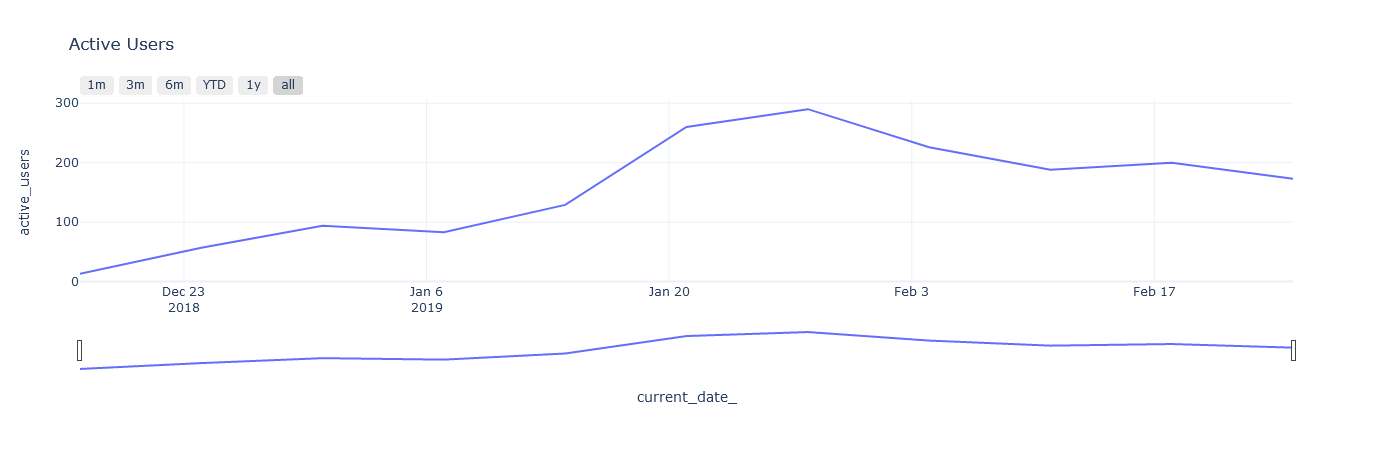

In [49]:
fig = Plot.time_series(df_active_users, x_data='current_date_', y_data='active_users', title='Active Users', selector_slider=True)
go.Figure(data=fig)
fig.show()

In [50]:
df_active_users

,current_date_,total_users,active_users,retention_rate
2,2018-12-17,86,13,15.12
3,2018-12-24,161,57,35.40
4,2018-12-31,186,94,50.54
5,2019-01-07,235,83,35.32
6,2019-01-14,544,129,23.71
7,2019-01-21,663,260,39.22
8,2019-01-28,557,290,52.06
9,2019-02-04,454,226,49.78
10,2019-02-11,458,188,41.05
11,2019-02-18,371,200,53.91


In [51]:
from datetime import timedelta 

In [59]:
start_date = df_active_users['current_date_'].min()
end_date = df_active_users['current_date_'].max()

df_active_users_now = df_active_users[(df_active_users['current_date_']==end_date)][['active_users', 'total_users']]
df_active_users_previous_week = df_active_users[(df_active_users['current_date_']==(end_date-timedelta(days=7)))][['active_users', 'total_users']]

active_users_now = df_active_users_now['active_users'].values[0]
perc_active_users_now = df_active_users_now['active_users'].values[0]/df_active_users_now['total_users'].values[0]*100

active_users_previous_week = df_active_users_previous_week['active_users'].values[0]
diff_active_users = active_users_now - active_users_previous_week

increase_active_users = diff_active_users/active_users_previous_week*100


-13.5

In [ ]:
df_users_active